# Explore jump session

In [1]:
import sys

sys.path.append("../..")

In [2]:
import numpy as np
import pandas as pd

import scipy.ndimage
import scipy.signal

from numba import jit

import matplotlib.pyplot as plt

from core_parser import collect, as_frames, open_raw

from lib import estimate_angles, normalize, quaternion_rotate

## Load sessions

In [3]:
# Load all related sessions
folder = "../../data/20221002/"
devices = [
    "upper_back",
    "left_arm",
    "right_arm",
    "left_foot",
    "right_foot",
]
sessions = {}
for device in devices:
    with open_raw(folder + device) as file:
        frames = as_frames(collect(file))
        sessions[device] = frames

## Align sessions

In [4]:
# Check time spans
for device in devices:
    session = sessions[device]
    last_ping = session["sys_ping_v2"].iloc[-1]
    end = pd.Timestamp.fromtimestamp(last_ping["us_since_epoch"] * 1e-6)
    duration = pd.Timedelta(last_ping["timestamp"], "ms")
    start = end - duration
    session["start"] = start
    print(f"{device}: {start} -> {end} ({duration})")

upper_back: 2022-10-02 13:12:50.453257 -> 2022-10-02 13:40:40.380257 (0 days 00:27:49.927000)
left_arm: 2022-10-02 13:12:57.680080 -> 2022-10-02 13:40:27.507080 (0 days 00:27:29.827000)
right_arm: 2022-10-02 13:12:42.117841 -> 2022-10-02 13:40:36.925841 (0 days 00:27:54.808000)
left_foot: 2022-10-02 13:12:54.227314 -> 2022-10-02 13:40:32.074314 (0 days 00:27:37.847000)
right_foot: 2022-10-02 13:12:45.734142 -> 2022-10-02 13:40:23.762142 (0 days 00:27:38.028000)


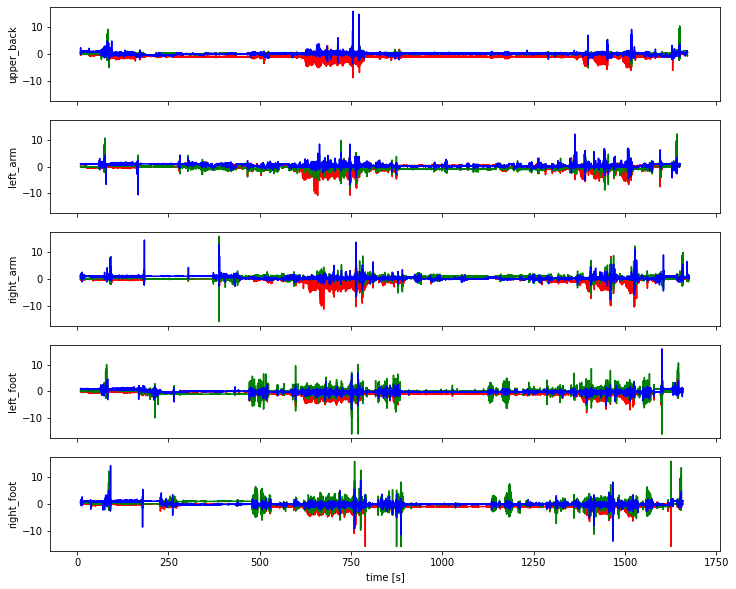

In [5]:
# Look for synchronization impacts
_, axes = plt.subplots(
    len(devices),
    sharex=True,
    sharey=True,
    figsize=(12, len(devices) * 2),
)
for i, ax in enumerate(axes):
    acc_df = sessions[devices[i]]["imu_acc"]
    ax.plot(acc_df["timestamp"] * 1e-3, acc_df["x"], c="r")
    ax.plot(acc_df["timestamp"] * 1e-3, acc_df["y"], c="g")
    ax.plot(acc_df["timestamp"] * 1e-3, acc_df["z"], c="b")
    ax.set_ylabel(devices[i])
axes[-1].set_xlabel("time [s]")
plt.show()

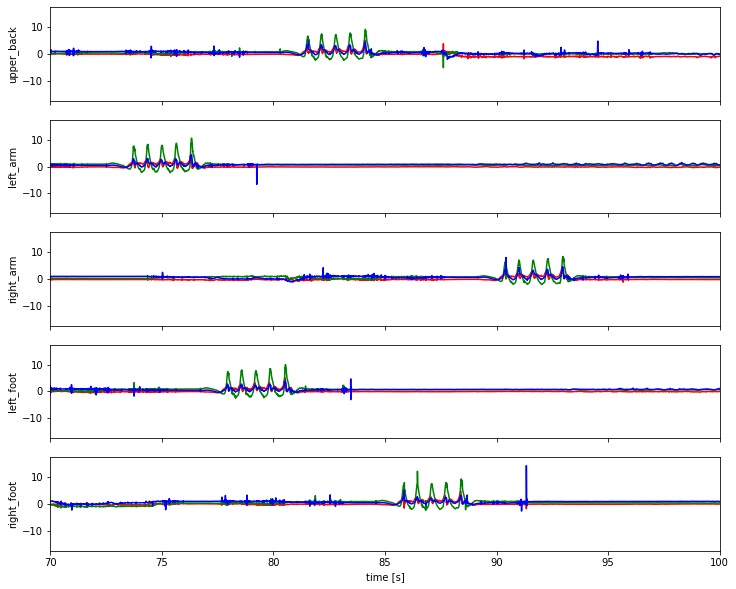

In [6]:
# Zoom in
_, axes = plt.subplots(
    len(devices),
    sharex=True,
    sharey=True,
    figsize=(12, len(devices) * 2),
)
for i, ax in enumerate(axes):
    acc_df = sessions[devices[i]]["imu_acc"]
    ax.plot(acc_df["timestamp"] * 1e-3, acc_df["x"], c="r")
    ax.plot(acc_df["timestamp"] * 1e-3, acc_df["y"], c="g")
    ax.plot(acc_df["timestamp"] * 1e-3, acc_df["z"], c="b")
    ax.set_ylabel(devices[i])
axes[-1].set_xlabel("time [s]")
axes[-1].set_xlim(70, 100)
plt.show()

In [7]:
# Sample rate of reference device
1000 / np.median(np.diff(sessions[devices[0]]["imu_acc"]["timestamp"]))

250.0

In [8]:
def get_resampled_acceleration_norm(frames, sample_rate):
    assert 1000 % sample_rate == 0
    acc_df = frames["imu_acc"]
    t = acc_df["timestamp"].values
    a = acc_df[["x", "y", "z"]].values
    n = np.sqrt((a ** 2).sum(axis=1))
    t_resampled = np.arange(t[0], t[-1], 1000 // sample_rate)
    n_resampled = np.interp(t_resampled, t, n)
    return t_resampled, n_resampled


# Use cross-correlation to align these signals (using upper as reference)
deltas = {}
deltas[devices[0]] = 0.0
for device in devices[1:]:

    # Get both signals at same rate
    sample_rate = 500
    t_ref, n_ref = get_resampled_acceleration_norm(sessions[devices[0]], sample_rate)
    t, n = get_resampled_acceleration_norm(sessions[device], sample_rate)

    # Compute correlation and associated lag
    # Note: for simplicity, we assume that sampling rate is constant and consistent
    correlation = scipy.signal.correlate(n_ref, n, mode="full")
    lags = scipy.signal.correlation_lags(n_ref.size, n.size, mode="full")
    lag = lags[np.argmax(correlation)]
    delta = lag * 1000 / sample_rate
    deltas[device] = delta

deltas

{'upper_back': 0.0,
 'left_arm': 7678.0,
 'right_arm': -8982.0,
 'left_foot': 3478.0,
 'right_foot': -4204.0}

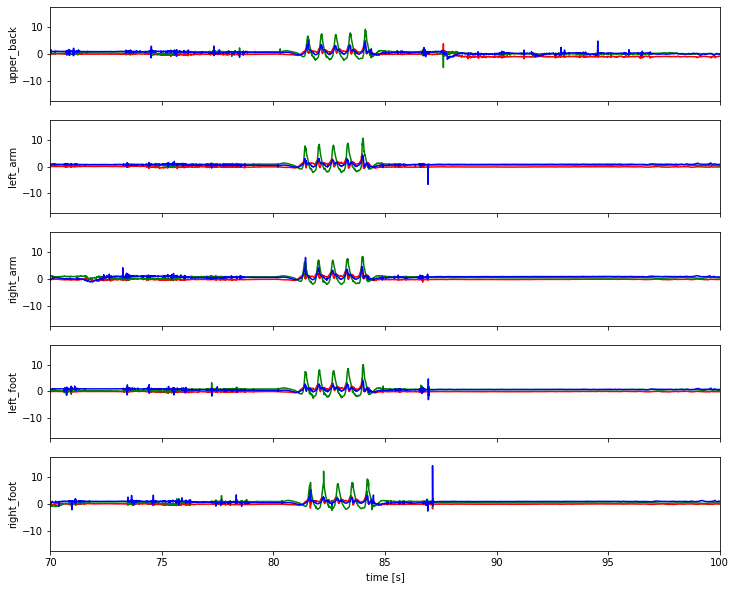

In [9]:
# Show fixed signals
_, axes = plt.subplots(
    len(devices),
    sharex=True,
    sharey=True,
    figsize=(12, len(devices) * 2),
)
for i, ax in enumerate(axes):
    acc_df = sessions[devices[i]]["imu_acc"]
    t = acc_df["timestamp"] + deltas[devices[i]]
    ax.plot(t * 1e-3, acc_df["x"], c="r")
    ax.plot(t * 1e-3, acc_df["y"], c="g")
    ax.plot(t * 1e-3, acc_df["z"], c="b")
    ax.set_ylabel(devices[i])
axes[-1].set_xlabel("time [s]")
axes[-1].set_xlim(70, 100)
plt.show()

## Prepare sessions

In [10]:
# Get time spans intersection
# Note: using quaternions as references
t_min = -np.inf
t_max = np.inf
for device in devices:
    frames = sessions[device]
    quat_df = frames["imu_quat"]
    t = quat_df["timestamp"].values.astype(np.int32) + deltas[device]
    t_min = max(t_min, t[0])
    t_max = min(t_max, t[-1])

In [11]:
# Resample at constant rate
sample_rate = 250
assert 1000 % sample_rate == 0
t = np.arange(t_min, t_max, 1000 // sample_rate)

# Process quaternions
Q = np.zeros((len(t), len(devices), 4), dtype=np.float32)
for i in range(len(devices)):
    frames = sessions[device]
    quat_df = frames["imu_quat"]
    t_i = quat_df["timestamp"].values.astype(np.int32) + deltas[device]
    q_i = quat_df[["w", "x", "y", "z"]].values
    for j in range(4):
        Q[:, i, j] = np.interp(t, t_i, q_i[:, j])

# Renormalize quaternions
Q /= np.sqrt((Q ** 2).sum(axis=2))[:, :, None]

# Process accelerations
A = np.zeros((len(t), len(devices), 3), dtype=np.float32)
for i in range(len(devices)):
    frames = sessions[device]
    acc_df = frames["imu_acc"]
    t_i = acc_df["timestamp"].values.astype(np.int32) + deltas[device]
    a_i = acc_df[["x", "y", "z"]].values
    for j in range(3):
        A[:, i, j] = np.interp(t, t_i, a_i[:, j])

In [12]:
# Fix axes, according to our conventions
# Note: Z is pointing down, X is pointing forward, Y is pointing right
W = np.array(
    [
        [0, 1, 0, 0],
        [0, 0, -1, 0],
        [0, 0, 0, 1],
        [-1, 0, 0, 0],
    ]
)
Q = Q @ W.T
A[..., 0] *= -1
A[..., 2] *= -1

In [13]:
# Using standard units, for convenience
t = t * 1e-3
A *= 9.81

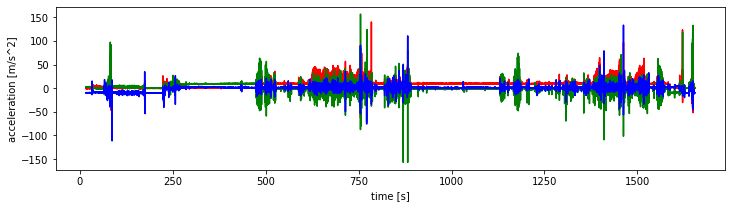

In [14]:
# Show raw acceleration of upper body
i = 0
_, ax = plt.subplots(figsize=(12, 3))
ax.plot(t, A[:, i, 0], c="r")
ax.plot(t, A[:, i, 1], c="g")
ax.plot(t, A[:, i, 2], c="b")
ax.set_ylabel("acceleration [m/s^2]")
ax.set_xlabel("time [s]")
plt.show()

## Integrate acceleration

See [`explore_walk.ipynb`](../walk/explore_walk.ipynb) for more details on numerical integration.

In [15]:
# https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation#Quaternion-derived_rotation_matrix
def rotation_matrix(q):
    w = q[..., 0]
    x = q[..., 1]
    y = q[..., 2]
    z = q[..., 3]
    R = np.zeros((*q.shape[:-1], 3, 3), dtype=q.dtype)
    R[..., 0, 0] = 1 - 2 * (y * y + z * z)
    R[..., 0, 1] = 2 * (x * y - z * w)
    R[..., 0, 2] = 2 * (x * z + y * w)
    R[..., 1, 0] = 2 * (x * y + z * w)
    R[..., 1, 1] = 1 - 2 * (x * x + z * z)
    R[..., 1, 2] = 2 * (y * z - x * w)
    R[..., 2, 0] = 2 * (x * z - y * w)
    R[..., 2, 1] = 2 * (y * z + x * w)
    R[..., 2, 2] = 1 - 2 * (x * x + y * y)
    return R

In [16]:
# Get rotation matrix associated to quaternions (body to navigation)
R = rotation_matrix(Q)

# Get inverse matrix (navigation to body)
# Note: matrices are orthogonal, so transpose is equivalent
R_inv = R.transpose(0, 1, 3, 2)

In [17]:
# Get acceleration in navigation frame
ddx = (R @ A[..., None]).squeeze(-1)

# Remove gravity to get effective acceleration
ddx -= np.array([0.0, 0.0, -9.81])

In [18]:
# Simple numerical integration
@jit
def integrate_1d(t, dx, x0=0):
    assert t.shape == dx.shape
    (n,) = dx.shape
    x = np.zeros_like(dx)
    x[0] = x0
    for i in range(1, n):
        dt = t[i] - t[i - 1]
        x[i] = (dx[i - 1] + dx[i]) / 2 * dt + x[i - 1]
    return x

In [19]:
# Integrate each axis separately, to get velocity
dx = np.empty_like(ddx)
for i in range(ddx.shape[1]):
    for j in range(ddx.shape[2]):
        dx[:, i, j] = integrate_1d(t, ddx[:, i, j])

In [20]:
# High-pass filter on velocity
# Note: this makes the assumption that speed is usually 0
b, a = scipy.signal.butter(5, 0.2, "highpass", fs=sample_rate)
dx_highpass = scipy.signal.filtfilt(b, a, dx, axis=0)

In [21]:
# Integrate again each axis separately, to get position
x = np.empty_like(dx)
for i in range(dx.shape[1]):
    for j in range(dx.shape[2]):
        x[:, i, j] = integrate_1d(t, dx_highpass[:, i, j])

In [22]:
# High-pass filter on velocity
# Note: this makes the assumption that speed is usually 0
b, a = scipy.signal.butter(5, 0.2, "highpass", fs=sample_rate)
x_highpass = scipy.signal.filtfilt(b, a, x, axis=0)

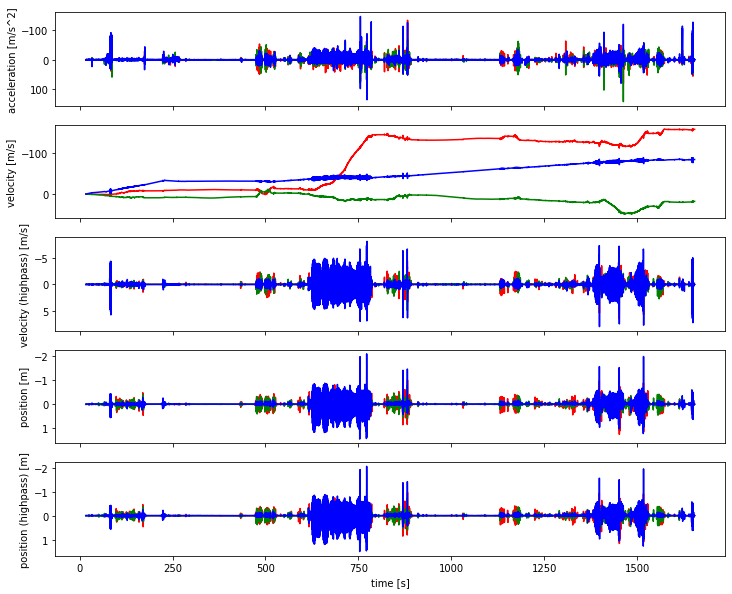

In [23]:
# Show various integration and filterings steps
# Note: the second high-pass filter seems unnecessary, at least at large scale
i = 0
_, axes = plt.subplots(5, sharex=True, figsize=(12, 10))
axes[0].plot(t, ddx[:, i, 0], c="r")
axes[0].plot(t, ddx[:, i, 1], c="g")
axes[0].plot(t, ddx[:, i, 2], c="b")
axes[0].set_ylabel("acceleration [m/s^2]")
axes[0].invert_yaxis()
axes[1].plot(t, dx[:, i, 0], c="r")
axes[1].plot(t, dx[:, i, 1], c="g")
axes[1].plot(t, dx[:, i, 2], c="b")
axes[1].set_ylabel("velocity [m/s]")
axes[1].invert_yaxis()
axes[2].plot(t, dx_highpass[:, i, 0], c="r")
axes[2].plot(t, dx_highpass[:, i, 1], c="g")
axes[2].plot(t, dx_highpass[:, i, 2], c="b")
axes[2].set_ylabel("velocity (highpass) [m/s]")
axes[2].invert_yaxis()
axes[3].plot(t, x[:, i, 0], c="r")
axes[3].plot(t, x[:, i, 1], c="g")
axes[3].plot(t, x[:, i, 2], c="b")
axes[3].set_ylabel("position [m]")
axes[3].invert_yaxis()
axes[4].plot(t, x_highpass[:, i, 0], c="r")
axes[4].plot(t, x_highpass[:, i, 1], c="g")
axes[4].plot(t, x_highpass[:, i, 2], c="b")
axes[4].set_ylabel("position (highpass) [m]")
axes[4].invert_yaxis()
axes[-1].set_xlabel("time [s]")
plt.show()

In [24]:
# The filter seems to be needed, if we want centimeter-level precision
dx = x - x_highpass
dx.min(), dx.max()

(-0.12792168109211954, 0.14659193806964266)

## Recorded trampoline session

In [25]:
# The whole trampoline session recorded on video spans 3 minutes
zero = sessions[devices[0]]["start"]
start = (pd.Timestamp("2022-10-02 13:22:50") - zero).total_seconds()
end = (pd.Timestamp("2022-10-02 13:26:10") - zero).total_seconds()

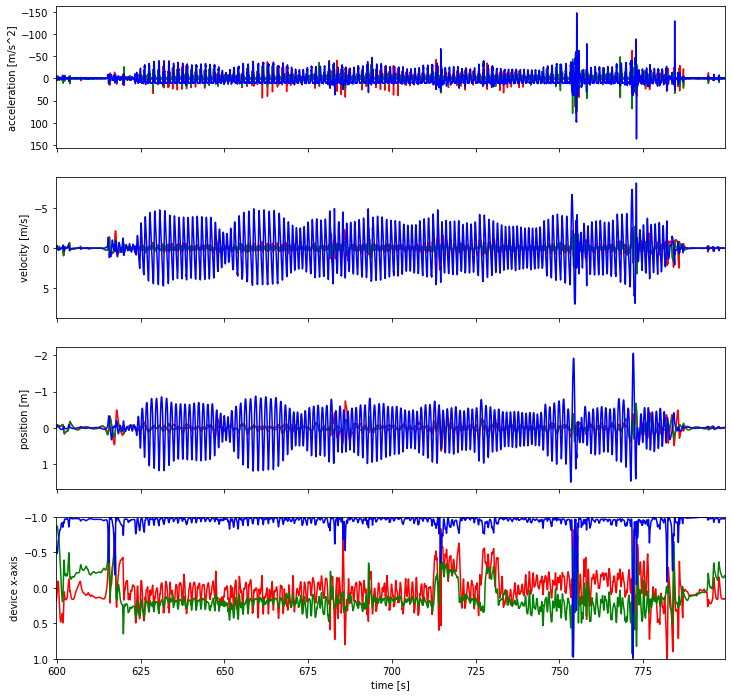

In [26]:
# Show upper back motion
i = 0
_, axes = plt.subplots(4, sharex=True, figsize=(12, 12))
axes[0].plot(t, ddx[:, i, 0], c="r")
axes[0].plot(t, ddx[:, i, 1], c="g")
axes[0].plot(t, ddx[:, i, 2], c="b")
axes[0].set_ylabel("acceleration [m/s^2]")
axes[0].invert_yaxis()
axes[1].plot(t, dx_highpass[:, i, 0], c="r")
axes[1].plot(t, dx_highpass[:, i, 1], c="g")
axes[1].plot(t, dx_highpass[:, i, 2], c="b")
axes[1].set_ylabel("velocity [m/s]")
axes[1].invert_yaxis()
axes[2].plot(t, x_highpass[:, i, 0], c="r")
axes[2].plot(t, x_highpass[:, i, 1], c="g")
axes[2].plot(t, x_highpass[:, i, 2], c="b")
axes[2].set_ylabel("position [m]")
axes[2].invert_yaxis()
axes[3].plot(t, R[:, i, 0, 0], c="r")
axes[3].plot(t, R[:, i, 1, 0], c="g")
axes[3].plot(t, R[:, i, 2, 0], c="b")
axes[3].set_ylim(-1, 1)
axes[3].set_ylabel("device x-axis")
axes[3].invert_yaxis()
axes[-1].set_xlabel("time [s]")
axes[-1].set_xlim(start, end)
plt.show()

## Salto

In [27]:
# TODO fix this!

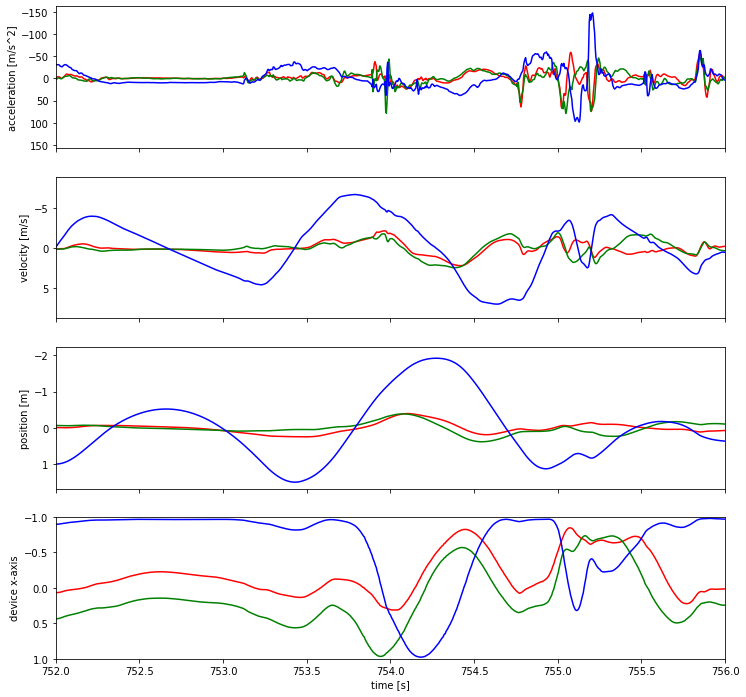

In [28]:
# Show upper back motion
i = 0
center = 754
_, axes = plt.subplots(4, sharex=True, figsize=(12, 12))
axes[0].plot(t, ddx[:, i, 0], c="r")
axes[0].plot(t, ddx[:, i, 1], c="g")
axes[0].plot(t, ddx[:, i, 2], c="b")
axes[0].set_ylabel("acceleration [m/s^2]")
axes[0].invert_yaxis()
axes[1].plot(t, dx_highpass[:, i, 0], c="r")
axes[1].plot(t, dx_highpass[:, i, 1], c="g")
axes[1].plot(t, dx_highpass[:, i, 2], c="b")
axes[1].set_ylabel("velocity [m/s]")
axes[1].invert_yaxis()
axes[2].plot(t, x_highpass[:, i, 0], c="r")
axes[2].plot(t, x_highpass[:, i, 1], c="g")
axes[2].plot(t, x_highpass[:, i, 2], c="b")
axes[2].set_ylabel("position [m]")
axes[2].invert_yaxis()
axes[3].plot(t, R[:, i, 0, 0], c="r")
axes[3].plot(t, R[:, i, 1, 0], c="g")
axes[3].plot(t, R[:, i, 2, 0], c="b")
axes[3].set_ylim(-1, 1)
axes[3].set_ylabel("device x-axis")
axes[3].invert_yaxis()
axes[-1].set_xlabel("time [s]")
axes[-1].set_xlim(center - 2, center + 2)
plt.show()

In [29]:
# Focus on a subset
start_index, end_index = np.searchsorted(t, [center - 4, center + 4])
step_duration = 0.1
step = int(sample_rate * step_duration)

# Select x-axis as the main facing direction
# Note: the device is on the chest, so -Z is forward
ex = (R[start_index:end_index, 0] @ np.array([0.0, 0.0, -1.0])).mean(axis=0)
ex[2] = 0.0
ex = normalize(ex)

# Select y-axis as upward
ey = np.array([0.0, 0.0, -1.0])

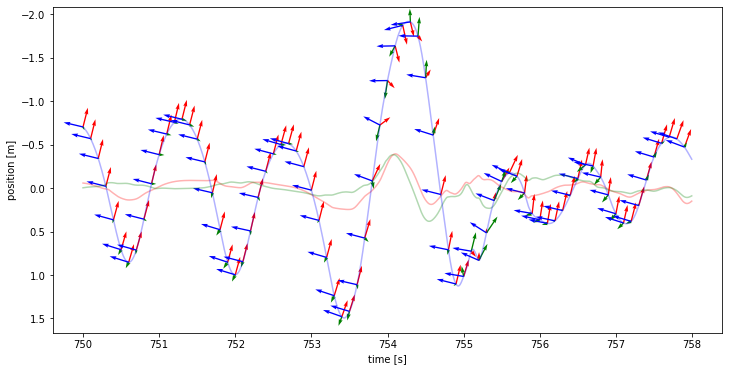

In [30]:
# Show orientation over time
_, ax = plt.subplots(figsize=(12, 6))

# Add position
ax.plot(
    t[start_index:end_index], x_highpass[start_index:end_index, i, 0], c="r", alpha=0.3
)
ax.plot(
    t[start_index:end_index], x_highpass[start_index:end_index, i, 1], c="g", alpha=0.3
)
ax.plot(
    t[start_index:end_index], x_highpass[start_index:end_index, i, 2], c="b", alpha=0.3
)
ax.set_ylabel("position [m]")

# Add arrows to show orientation
for j, c in enumerate("rgb"):
    ax.quiver(
        t[start_index:end_index:step],
        x_highpass[start_index:end_index:step, i, 2],
        R[start_index:end_index:step, i, :, j] @ ex,
        R[start_index:end_index:step, i, :, j] @ ey,
        color=c,
        scale_units="dots",
        scale=0.05,
        width=0.002,
    )

ax.set_xlabel("time [s]")
ax.invert_yaxis()
plt.show()

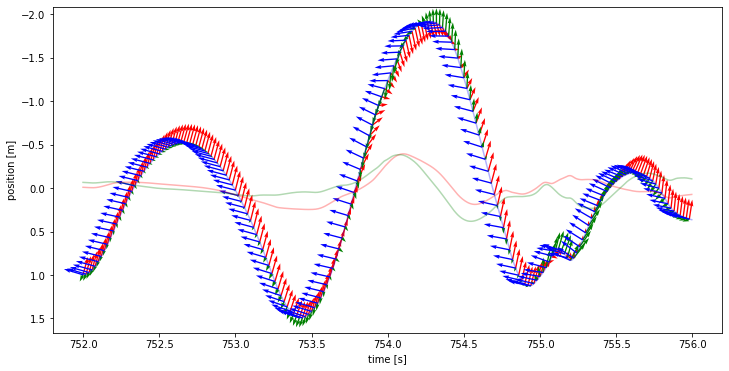

In [31]:
# Zoom in, including direction of X-axis (pointing upward on the torso)
start_index, end_index = np.searchsorted(t, [center - 2, center + 2])
step_duration = 0.02
step = int(sample_rate * step_duration)
_, ax = plt.subplots(figsize=(12, 6))

# Add position
ax.plot(
    t[start_index:end_index], x_highpass[start_index:end_index, i, 0], c="r", alpha=0.3
)
ax.plot(
    t[start_index:end_index], x_highpass[start_index:end_index, i, 1], c="g", alpha=0.3
)
ax.plot(
    t[start_index:end_index], x_highpass[start_index:end_index, i, 2], c="b", alpha=0.3
)
ax.set_ylabel("position [m]")

# Add arrows to show orientation
for j, c in enumerate("rgb"):
    ax.quiver(
        t[start_index:end_index:step],
        x_highpass[start_index:end_index:step, i, 2],
        R[start_index:end_index:step, i, :, j] @ ex,
        R[start_index:end_index:step, i, :, j] @ ey,
        color=c,
        scale_units="dots",
        scale=0.05,
        width=0.002,
    )

ax.set_xlabel("time [s]")
ax.invert_yaxis()
plt.show()